# Tarea 2 - Regresion Polinomial & Feature engineering

### Parte 1 - Modelo exponencial de covid-19 usando feature-eng

Usando el ejemplo de covid-19 en el notebook de feature-eng (https://colab.research.google.com/drive/1sJV2HG7tQgCGKES3-dIclzHQJ9qAWB3b?usp=sharing) crear un modelo de covid-19 para Guatemala.

* Convertir la fecha a un entero "número de día", por ejemplo si se usan datos desde el 22 de abril, este es el día 0, el 23 es el día 1.
* Aplicar regresión lineal sobre la variable "Confirmed" transformada.
* Una vez entrenado el modelo usarlo para aproximar la cantidad de casos confirmados para el 6 de Junio. Se debe reportar la cantidad de casos, no la cantidad transformada obtenida.

In [60]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from datetime import datetime
import seaborn as sb

In [116]:
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Enabled compatitility to tf1.x


#### Carga de datos

In [4]:
covid19_data = pd.read_csv('covid_19_clean_complete.csv')
covid19_data["Date"] = pd.to_datetime(covid19_data["Date"],infer_datetime_format = True)
covid19_data.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.0000,65.0000,2020-01-22,0,0,0
1,NaN,Albania,41.1533,20.1683,2020-01-22,0,0,0
2,NaN,Algeria,28.0339,1.6596,2020-01-22,0,0,0
3,NaN,Andorra,42.5063,1.5218,2020-01-22,0,0,0
4,NaN,Angola,-11.2027,17.8739,2020-01-22,0,0,0


In [6]:
covid19_data.dtypes

Province/State            object
Country/Region            object
Lat                      float64
Long                     float64
Date              datetime64[ns]
Confirmed                  int64
Deaths                     int64
Recovered                  int64
dtype: object

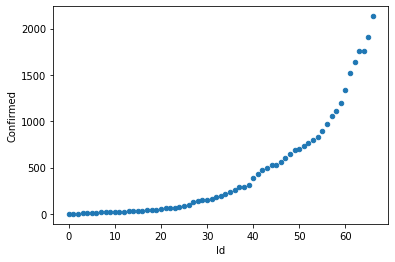

In [22]:
## Filtro de datos
GT_confirmed = covid19_data[(covid19_data["Country/Region"] == 'Guatemala') & (covid19_data["Confirmed"] > 0)].copy()

# reset de index
GT_confirmed = GT_confirmed.reset_index(drop=True)
# asignacion
GT_confirmed["Id"] = GT_confirmed.index

# Despliegue
GT_confirmed.plot.scatter(x = "Id",y="Confirmed")


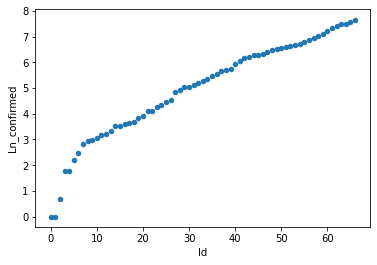

In [23]:
# Transformacion
GT_confirmed["Ln_confirmed"] = np.log(GT_confirmed["Confirmed"])
GT_confirmed.plot.scatter(x = "Id",y="Ln_confirmed")

In [26]:
GT_confirmed.head(10)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Id,Ln_confirmed
0,NaN,Guatemala,15.7835,-90.2308,2020-03-14,1,0,0,0,0.000000
1,NaN,Guatemala,15.7835,-90.2308,2020-03-15,1,0,0,1,0.000000
2,NaN,Guatemala,15.7835,-90.2308,2020-03-16,2,1,0,2,0.693147
3,NaN,Guatemala,15.7835,-90.2308,2020-03-17,6,1,0,3,1.791759
4,NaN,Guatemala,15.7835,-90.2308,2020-03-18,6,1,0,4,1.791759
5,NaN,Guatemala,15.7835,-90.2308,2020-03-19,9,1,0,5,2.197225
6,NaN,Guatemala,15.7835,-90.2308,2020-03-20,12,1,0,6,2.484907
7,NaN,Guatemala,15.7835,-90.2308,2020-03-21,17,1,0,7,2.833213
8,NaN,Guatemala,15.7835,-90.2308,2020-03-22,19,1,0,8,2.944439
9,NaN,Guatemala,15.7835,-90.2308,2020-03-23,20,1,0,9,2.995732


Se difinio el limite inicial como *21 de marzo* y el sugerido inicial que era el 22

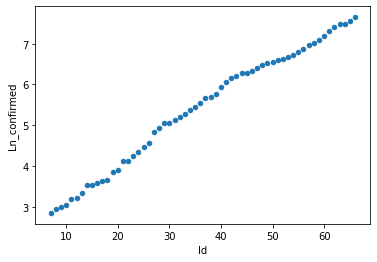

In [173]:
GT_confirmed_post24 = GT_confirmed[GT_confirmed.Date >= '2020-03-21']
GT_confirmed_post24.plot.scatter(x = "Id",y="Ln_confirmed")

In [30]:
### Objeto del modelo
class GradientDesend:
    def __init__(self,b0=0.,b1=0.):
        tf.reset_default_graph()
        self.b0 = tf.get_variable("B0",dtype=tf.float32,
                                  shape=[],initializer=tf.constant_initializer(b0))
        self.b1 = tf.get_variable("B1",dtype=tf.float32,
                                  shape=[],initializer=tf.constant_initializer(b1))
        self.error = tf.get_variable("error",dtype=tf.float32,
                                  shape=[],initializer=tf.zeros_initializer())
        
    def step(self,x,y,lr):
        # hipotesis
        yhat = tf.matmul(x,[[self.b0],[self.b1]],name="yhat") 

        error = tf.reduce_mean(tf.math.square(y - yhat) ,name="reduce_mean")/2

        grad = tf.gradients(error,[self.b0,self.b1], name = "gradients")
        
        
        local_b0 = tf.assign(self.b0, self.b0 - lr*grad[0] , name="assign_b0")
        local_b1 = tf.assign(self.b1, self.b1 - lr*grad[1] , name="assign_b1")
        local_error = tf.assign(self.error, error , name="assign_error")
        
        
        salida = tf.group(local_b0,local_b1,local_error, name="grupo")

        return salida

In [237]:
tf.reset_default_graph()


# valores iniciales
init_b0 = 0
init_b1 = 2
lr = 0.0005
status = 5
largo = len(GT_confirmed_post24["Id"])
batch_size = 5 
epochs = 100
iteraciones = int(largo/batch_size)
gd = GradientDesend(init_b0,init_b1)

dat_x = tf.placeholder(tf.float32,[None,2],"Value_x")
dat_y = tf.placeholder(tf.float32,[None],"Value_y")

step = gd.step(dat_x,dat_y,lr)

# se agrega unos a los valores de X para operarlo como matriz
nc = np.ones_like(GT_confirmed_post24["Id"])
x = np.hstack((np.expand_dims(GT_confirmed_post24["Id"],1),np.expand_dims(nc,1))) 


error_summary = tf.summary.scalar('error', gd.error)

with tf.train.MonitoredSession() as session:
    localdir = "logs_tarea2/MiniBgradient_" + datetime.now().strftime("%Y%m%d-%H%M%S") + "_lr=" + str(lr) + "_b0="+ str(init_b0) + "_b1="+ str(init_b1)
    writer = tf.summary.FileWriter(localdir , session.graph)

    
    for i in range(epochs):
        for j in range(iteraciones):
            inicio = j * batch_size
            fin = inicio + batch_size
            
            feed_dict = {dat_x:x[inicio:fin], dat_y:GT_confirmed_post24["Ln_confirmed"][inicio:fin]}
            session.run(step,feed_dict=feed_dict)
            summary = session.run(error_summary,feed_dict=feed_dict)
            writer.add_summary(summary, i)
        if i%status ==0:
            b0,b1,error = session.run([gd.b0,gd.b1,gd.error],feed_dict=feed_dict)
            print(b0,b1,error)
    
    
    b0,b1,error = session.run([gd.b0,gd.b1,gd.error],feed_dict=feed_dict)
    print("y = {}x + {} [{}]".format(b0,b1,error))

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
0.08516215 2.0040746 0.012906948
0.08513822 2.00604 0.0128790215
0.08510892 2.0079987 0.012869404
0.08507979 2.0099478 0.012859825
0.085050754 2.0118897 0.012850311
0.08502185 2.0138228 0.012840836
0.08499306 2.0157485 0.012831447
0.084964395 2.0176656 0.012822062
0.084935844 2.019575 0.0128127225
0.08490741 2.0214763 0.012803449
0.08487912 2.0233686 0.012794204
0.084850945 2.0252533 0.012785044
0.084822856 2.0271318 0.012775901
0.084794894 2.029002 0.012766791
0.08476707 2.0308633 0.012757769
0.08473936 2.0327172 0.012748728
0.08471177 2.0345623 0.012739766
0.084684275 2.0364006 0.012730872
0.08465692 2.0382314 0.01272198
0.08462964 2.0400553 0.012713175
y = 0.08460792154073715x + 2.0415077209472656 [0.012706146575510502]


##### Visualizacion de resultado
Grafica de prediccion

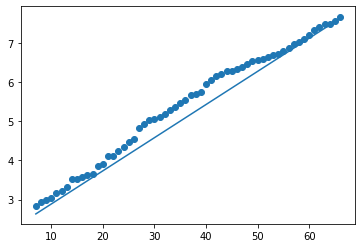

In [238]:
yhat = GT_confirmed_post24["Id"] * b0 + b1
plt.scatter(GT_confirmed_post24["Id"],GT_confirmed_post24["Ln_confirmed"])
plt.plot(GT_confirmed_post24["Id"],yhat,label=str(i))

#### Prueba del modelo para 6 de junio

Una vez entrenado el modelo usarlo para aproximar la cantidad de casos confirmados para el *6 de Junio*. Se debe reportar la cantidad de casos, no la cantidad transformada obtenida.

Seria para el **Id = 84**

In [231]:
GT_confirmed_post24.tail(5)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Id,Ln_confirmed,yhat
62,NaN,Guatemala,15.7835,-90.2308,2020-05-15,1643,30,135,62,7.404279,7.287199
63,NaN,Guatemala,15.7835,-90.2308,2020-05-16,1763,33,138,63,7.474772,7.371807
64,NaN,Guatemala,15.7835,-90.2308,2020-05-17,1763,33,138,64,7.474772,7.456415
65,NaN,Guatemala,15.7835,-90.2308,2020-05-18,1912,35,138,65,7.555905,7.541023
66,NaN,Guatemala,15.7835,-90.2308,2020-05-19,2133,43,155,66,7.665285,7.625631


In [232]:
id_pronostico = 84
estimacion_inicial = id_pronostico * b0 + b1
estimacion_inicial

9.148573130369186

In [233]:
proyeccion = np.exp(estimacion_inicial)
proyeccion

9401.016778831738

La proyeccion para el 6 de junio es **9,401**

#### Conclusiones

En los primeros experimentos se utilizo Batch Gradient Descent y los resultados a pesar que eran convergentes no se logro tener una buena aproximacion; las mejores reducciones estaban alrededor de un *3.58*; como se muestra en la siguiente imagen (en la ruta [log_tarea2_GD](https://github.com/HectorMendia/StatisticalLearning1/tree/master/log_tarea2_GD) estan las ejecuciones y configuraciones)

<img src="Tarea2Scalar.PNG" width="1000px">

Cuando se cambio a un proceso de MiniBatch, el error se redujo significativamente a *0.012706* 

<img src="Tarea2ScalarMB.PNG" width="1000px">

El mejor resultado de experimiento se encontro con los parametros:
* Learning rate = 0.0005
* beta0 = 0
* beta1 = 2 
* ephocs = 100

Algo importante para lograr tener una buena aproximacion de la regresion fue asignar el valor b1 = 2 y no dejarlo con inicializacion 0; esto redujo significativamente la cantidad de iteraciones para reducir el error en este caso aproximadamente a la mitad (en la ruta [logs_tarea2](https://github.com/HectorMendia/StatisticalLearning1/tree/master/logs_tarea2) estan las ejecuciones y configuraciones)

#### b0 = 0

<img src="Tarea2ScalarMB_b00_b10.PNG" width="1000px">

#### b0 = 2

<img src="Tarea2ScalarMB_b00_b12.PNG" width="1000px">



### Parte 2 - Modelo polinomial de calidad de vinos

Es permitido utilizar [sklearn.preprocessing.polynomialfeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)


### Instrucciones

1. Seleccionar y transformar(generando las combinaciones polinomiales para un polinomio de grado dos o tres a elección) las features que considere que son las mejores para predecir la calidad del vino, utilizar como minimo 2 features. Para seleccionar las features, hacer un analisis exploratorio por ejemplo(pero no limitado a ):  graficando y viendo la forma en que se comportan los datos.

 Por ejemplo, se tienen las features "a" y "b" y seleccionamos polinomio de grado 2, hacemos feature engineering para obtener :
 
 $[a,b,a^{2},b^{2},ab]$
 
 No olvidar el "bias" (parámetro multiplicado por 1) ,con lo cual el dataset puede quedar con las columnas:
 
 $[1,a,b,a^{2},b^{2},ab]$
2. Una vez transformada la data aplicar regresion lineal con las features polinomiales usando Tensorflow.

Requisitos adicionales:
* Se debe agregar al notebook un screenshot del grafo de tensorboard, simplificando(usando  names , y name_scope como visto en clase).

* Se debe generar un directorio de logs de tensorboard para cada corrida/experimento , con cada directorio identificando facilmente la configuración del experimento como visto en clase, por ejemplo para un experimento con learning rate = 0.1 , y polinomio grado 2  crear un directorio: lr=0.1_polinomio_grado=2. (Agregar al notebook un screenshot de estas gráficas)

* Concluir en markdown cual es el mejor modelo para este caso basado en la comparativa entre curvas de costo/error en tensorboard.

In [56]:
data = pd.read_csv('winequality-red.csv')

### Red Wine Quality Data

Se aplicará regresión para crear un modelo de la calidad de vino en función de características del mismo, siendo 1 el peor vino y 10 el mejor.

Variables de entrada:
1. fixed acidity 
2. volatile acidity 
3. citric acid 
4. residual sugar 
5. chlorides 
6. free sulfur dioxide 
7. total sulfur dioxide 
8. density 
9. pH 
10. sulphates 
11. alcohol 

Varaible a predecir: 
12. quality (puntuacion  entre 0 y 10) 



In [57]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [62]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


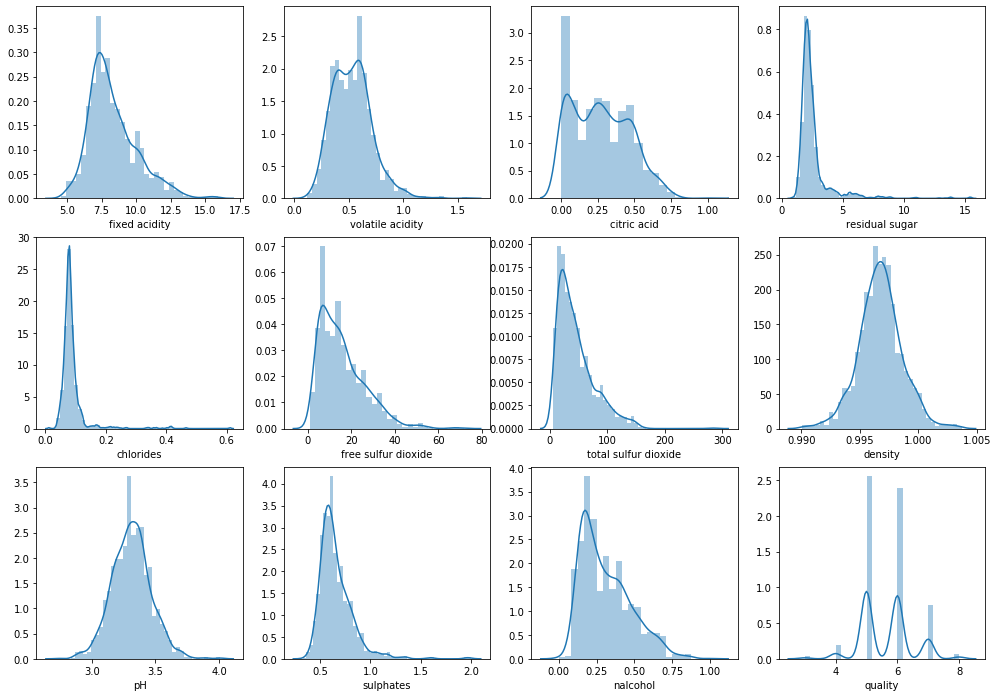

In [105]:
f, axes = plt.subplots(3, 4, figsize=(17, 12))
sb.distplot( data["fixed acidity"] , ax=axes[0, 0])
sb.distplot( data["volatile acidity"] , ax=axes[0, 1])
sb.distplot( data["citric acid"] , ax=axes[0, 2])
sb.distplot( data["residual sugar"] , ax=axes[0, 3])
sb.distplot( data["chlorides"] , ax=axes[1, 0])
sb.distplot( data["free sulfur dioxide"] , ax=axes[1, 1])
sb.distplot( data["total sulfur dioxide"] , ax=axes[1, 2])
sb.distplot( data["density"] , ax=axes[1, 3])
sb.distplot( data["pH"] , ax=axes[2, 0])
sb.distplot( data["sulphates"] , ax=axes[2, 1])
sb.distplot( data["nalcohol"] , ax=axes[2, 2])
sb.distplot( data["quality"] , ax=axes[2, 3])


In [108]:
#cof_mat = np.corrcoef([data[cols[1]],dt[cols[2]],dt[cols[3]],dt[cols[4]],dt[cols[5]],dt["quality"]])
#coef = cof_mat[5:][0]
#coef = np.corrcoef([data[1],data["quality"]])
#coef
#cof_mat = np.corrcoef(data[["fixed acidity","fixed acidity","citric acid","residual sugar","chlorides","free sulfur dioxide","total sulfur dioxide","density","pH","sulphates","alcohol"]],data["quality"])
#cof_mat
cof_mat = np.corrcoef([data["fixed acidity"],data["volatile acidity"],data["citric acid"],data["residual sugar"],data["chlorides"],
                       data["free sulfur dioxide"],data["total sulfur dioxide"],data["density"],data["pH"],data["sulphates"],data["alcohol"]],data["nquality"])

coef = cof_mat[11:][0]     
print(coef)

[ 0.12405165 -0.39055778  0.22637251  0.01373164 -0.12890656 -0.05065606
 -0.18510029 -0.17491923 -0.05773139  0.25139708  0.47616632  1.        ]


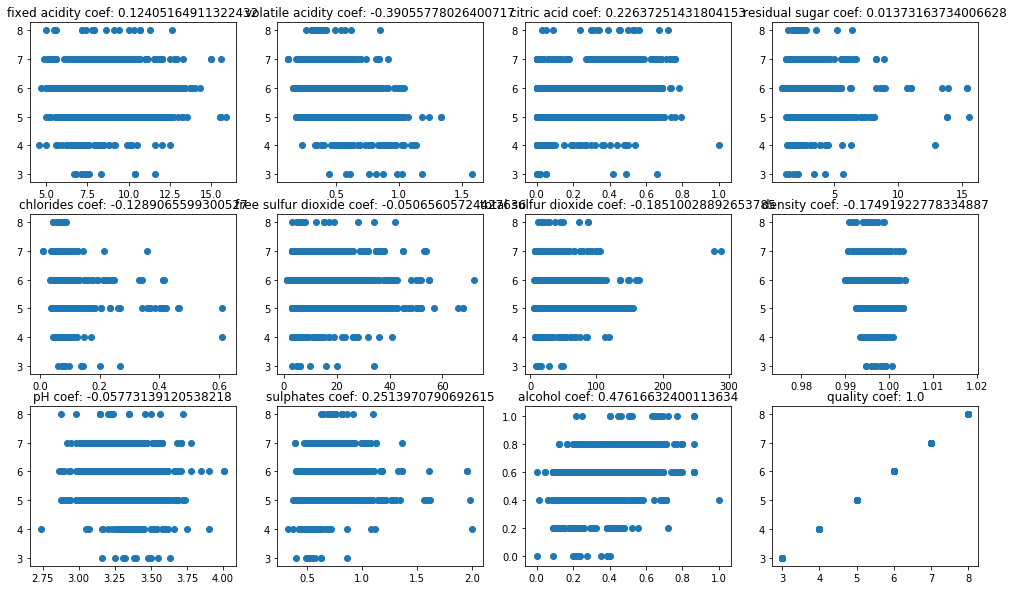

In [109]:
fig, axs = plt.subplots(3, 4, figsize=(17, 10))
axs[0, 0].scatter(data["fixed acidity"],data["quality"])
axs[0, 0].set_title("fixed acidity coef: " + str(coef[0]))

axs[0, 1].scatter(data["volatile acidity"],data["quality"])
axs[0, 1].set_title("volatile acidity coef: " + str(coef[1]))

axs[0, 2].scatter(data["citric acid"],data["quality"])
axs[0, 2].set_title("citric acid coef: " + str(coef[2]))

axs[0, 3].scatter(data["residual sugar"],data["quality"])
axs[0, 3].set_title("residual sugar coef: " + str(coef[3]))

axs[1, 0].scatter(data["chlorides"],data["quality"])
axs[1, 0].set_title("chlorides coef: " + str(coef[4]))

axs[1, 1].scatter(data["free sulfur dioxide"],data["quality"])
axs[1, 1].set_title("free sulfur dioxide coef: " + str(coef[5]))

axs[1, 2].scatter(data["total sulfur dioxide"],data["quality"])
axs[1, 2].set_title("total sulfur dioxide coef: " + str(coef[6]))

axs[1, 3].scatter(data["density"],data["quality"])
axs[1, 3].set_title("density coef: " + str(coef[7]))

axs[2, 0].scatter(data["pH"],data["quality"])
axs[2, 0].set_title("pH coef: " + str(coef[8]))

axs[2, 1].scatter(data["sulphates"],data["quality"])
axs[2, 1].set_title("sulphates coef: " + str(coef[9]))

axs[2, 2].scatter(data["nalcohol"],data["nquality"])
axs[2, 2].set_title("alcohol coef: " + str(coef[10]))

axs[2, 3].scatter(data["quality"],data["quality"])
axs[2, 3].set_title("quality coef: " + str(coef[11]))

plt.show()

In [ ]:
Se tomaran los datos con mayor indice de correlacion

In [197]:
data["nfixed acidity"] = (data["fixed acidity"] - np.min(data["fixed acidity"]))/ (np.max(data["fixed acidity"])-np.min(data["fixed acidity"]))
data["nvolatile acidity"] = (data["volatile acidity"] - np.min(data["volatile acidity"]))/ (np.max(data["volatile acidity"])-np.min(data["volatile acidity"]))
data["ncitric acid"] = (data["citric acid"] - np.min(data["citric acid"]))/ (np.max(data["citric acid"])-np.min(data["citric acid"]))
data["nresidual sugar"] = (data["residual sugar"] - np.min(data["residual sugar"]))/ (np.max(data["residual sugar"])-np.min(data["residual sugar"]))
data["nchlorides"] = (data["chlorides"] - np.min(data["chlorides"]))/ (np.max(data["chlorides"])-np.min(data["chlorides"]))
data["nfree sulfur dioxide"] = (data["free sulfur dioxide"] - np.min(data["free sulfur dioxide"]))/ (np.max(data["free sulfur dioxide"])-np.min(data["free sulfur dioxide"]))
data["ntotal sulfur dioxide"] = (data["total sulfur dioxide"] - np.min(data["total sulfur dioxide"]))/ (np.max(data["total sulfur dioxide"])-np.min(data["total sulfur dioxide"]))
data["ndensity"] = (data["density"] - np.min(data["density"]))/ (np.max(data["density"])-np.min(data["density"]))
data["npH"] = (data["pH"] - np.min(data["pH"]))/ (np.max(data["pH"])-np.min(data["pH"]))
data["nsulphates"] = (data["sulphates"] - np.min(data["sulphates"]))/ (np.max(data["sulphates"])-np.min(data["sulphates"]))
data["nalcohol"] = (data["alcohol"] - np.min(data["alcohol"]))/ (np.max(data["alcohol"])-np.min(data["alcohol"]))
data["nquality"] = (data["quality"] - np.min(data["quality"]))/ (np.max(data["quality"])-np.min(data["quality"]))

In [198]:
ncof_mat = np.corrcoef([data["nfixed acidity"],data["nvolatile acidity"],data["ncitric acid"],data["nresidual sugar"],data["nchlorides"],
                       data["nfree sulfur dioxide"],data["ntotal sulfur dioxide"],data["ndensity"],data["npH"],data["nsulphates"],data["nalcohol"]],data["nquality"])

ncoef = ncof_mat[11:][0]     
print(ncoef)

[ 0.12405165 -0.39055778  0.22637251  0.01373164 -0.12890656 -0.05065606
 -0.18510029 -0.17491923 -0.05773139  0.25139708  0.47616632  1.        ]


In [239]:
from sklearn.preprocessing import PolynomialFeatures

In [240]:
data_wine = data[["ncitric acid","nalcohol"]].copy()
data_wine

,ncitric acid,nalcohol
0,0.00,0.153846
1,0.00,0.215385
2,0.04,0.215385
3,0.56,0.215385
4,0.00,0.153846
...,...,...
1594,0.08,0.323077
1595,0.10,0.430769
1596,0.13,0.400000
1597,0.12,0.276923


In [246]:
# Feature Enge
feat_eng= PolynomialFeatures(2)
feat_wine = feat_eng.fit_transform(data_wine)
feat_wine

array([[1.        , 0.        , 0.15384615, 0.        , 0.        ,
        0.02366864],
       [1.        , 0.        , 0.21538462, 0.        , 0.        ,
        0.04639053],
       [1.        , 0.04      , 0.21538462, 0.0016    , 0.00861538,
        0.04639053],
       ...,
       [1.        , 0.13      , 0.4       , 0.0169    , 0.052     ,
        0.16      ],
       [1.        , 0.12      , 0.27692308, 0.0144    , 0.03323077,
        0.07668639],
       [1.        , 0.47      , 0.4       , 0.2209    , 0.188     ,
        0.16      ]])

In [274]:
feat_wine.shape

(1599, 6)

In [387]:
### Cambio del modelo para que trabaje con un grado mayor
class GradientDesendPol:
    def __init__(self):
        tf.reset_default_graph()
        self.bn = tf.get_variable("bns",dtype=tf.float32,
                                  shape=[1,6],initializer =tf.zeros_initializer() )
        self.error = tf.get_variable("error_total",dtype=tf.float32,
                                  shape=[],initializer=tf.zeros_initializer())
        
    def step(self,x,y,lr):
        # hipotesis
        yhat = tf.matmul(x,tf.transpose(self.bn, name = "transpose"),name="yhat") 

        error = tf.reduce_mean(tf.math.square(y - yhat) ,name="reduce_mean")/2

        grad = tf.gradients(error,self.bn, name = "gradients")
        
        
        local_bn = tf.assign(self.bn, self.bn - tf.multiply(lr,grad,name="multi_lr_grad")[0], name="assign_bn")
        local_error = tf.assign(self.error, error , name="assign_error")        
        
        salida = tf.group(local_bn,local_error, name="grupo")

        return salida

In [388]:
tf.reset_default_graph()


# valores iniciales
lr = 0.02
status = 100
largo = len(feat_wine)
batch_size = 123
epochs = 500
iteraciones = int(largo/batch_size)
gd = GradientDesendPol()

dat_x = tf.placeholder(tf.float32,[None,6],"Value_x")
dat_y = tf.placeholder(tf.float32,[None],"Value_y")

step = gd.step(dat_x,dat_y,lr)

error_summary = tf.summary.scalar('error', gd.error)

with tf.train.MonitoredSession() as session:
    localdir = "logs_tarea2_part2/MBG_" + datetime.now().strftime("%Y%m%d-%H%M%S") + "_lr=" + str(lr) + "_pol=2_batch="+ str(batch_size)
    writer = tf.summary.FileWriter(localdir , session.graph)
    
    for i in range(epochs):
        for j in range(iteraciones):
            inicio = j * batch_size
            fin = inicio + batch_size
            
            feed_dict = {dat_x:feat_wine[inicio:fin], dat_y:data["nquality"][inicio:fin]}
            session.run(step,feed_dict=feed_dict)
            summary = session.run(error_summary,feed_dict=feed_dict)
            writer.add_summary(summary, i)
        if i%status ==0:
            bn,error = session.run([gd.bn,gd.error],feed_dict=feed_dict)
            print(bn,error)
    
    
    bn,error = session.run([gd.bn,gd.error],feed_dict=feed_dict)
    print("y = {} [{}]".format(bn[0],error))

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[[0.11906797 0.03294112 0.03706072 0.01369833 0.01071815 0.01475527]] 0.082025476
[[0.47370797 0.06682619 0.09956277 0.01169411 0.00858574 0.01810383]] 0.011843408
[[0.48459217 0.05418627 0.08837375 0.00111536 0.00180613 0.00480354]] 0.011771166
[[ 0.48747468  0.05163256  0.08547531 -0.00242421  0.00159003 -0.00100809]] 0.011755056
[[ 0.48817882  0.05129781  0.08525922 -0.00431978  0.00305898 -0.0044003 ]] 0.011750692
y = [ 0.48827586  0.05140343  0.08591517 -0.00580675  0.00491245 -0.00694433] [0.0117495683953166]


#### Conlusion

El mejor modelo encontrado segun lo datos recabados es el que tiene un 
 * Learning Rate = 0.02
 * Tamaño batch = 123

Se probararon diversas combinaciones de parametros por encima y po debajo de los mencionando anteriormente y con estos se logro un error de **0.0117495**

Esto tambien se puede corroborar con la imagen siguiente
<img src="Tarea2ScalarMB_lr0002_b123.PNG" width="1000px">

El modelo es el siguiente

<img src="Tarea2Model_part2.PNG">

Las ejecuciones de prueba del modelo estan en [logs_tarea2_part2](https://github.com/HectorMendia/StatisticalLearning1/tree/master/logs_tarea2_part2); las primeras corridas fueron con menos epochs para tener una idea que que parametros podrian tener una mejor aproximacion a largo plazo

*A diferencia de la seccion 1, la inicializacion de valores fue con 0; es posible que con valores distintos se logre una mejor aproximacion como ocurrio en la parte uno de los casos de covid.*
